# Exersice 1

In [10]:
import sage.all
import random as pyrandom 
from random import shuffle, choice, randint
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

In [11]:
lattice_dimension = 20
hadamard_ratio_threshold = 0.8
lattice_spread = 10
message_vector_bound = 1
noise_vector_bound = 2

In [12]:
def hadamard_ratio(basis):
    # Compute the Hadamard ratio of basis B
    determinant_val = abs(basis.det())
    prod_norms = prod(basis.row(i).norm() for i in range(lattice_dimension))
    return ((determinant_val / prod_norms)**(1/lattice_dimension)).n()

def basis_diagonal_dominant(n, spread, scale=None):
    if scale is None:
        scale = int(sqrt(n) * spread)
    R = matrix(ZZ, [[ZZ.random_element(-spread, spread+1) for _ in range(n)] for _ in range(n)])
    return R + scale * identity_matrix(ZZ, n)

def random_signed_permutation(n):
    # random permutation pi
    pi = list(range(n))
    shuffle(pi)
    # permutation matrix P
    P = matrix(ZZ, n, n, 0)
    for i in range(n):
        P[i, pi[i]] = 1
    # random signs on rows
    signs = [1 if ZZ.random_element(0,2)==0 else -1 for _ in range(n)]
    S = diagonal_matrix(signs)
    # signed permutation
    return S * P  # orthogonal over R, unimodular over Z

def generate_private_key(dimension, spread, scramble_rows=True, scramble_cols=True):
    while True:
        # 1) diagonal-dominant seed
        initial_basis = basis_diagonal_dominant(dimension, spread=spread)
        initial_hadamard_ratio = hadamard_ratio(initial_basis)
        #print("Initial Ratio : ", initial_hadamard_ratio)
        # 2) signed permutation scrambling on rows/columns (does not change Hadamard ratio)
        good_basis = initial_basis
        if scramble_rows:
            U = random_signed_permutation(dimension)
            good_basis = U * good_basis
        if scramble_cols:
            V = random_signed_permutation(dimension)
            good_basis = good_basis * V
        final_hadamard_ratio = hadamard_ratio(good_basis)
        if (final_hadamard_ratio > hadamard_ratio_threshold):
            print("Hadamard Ratio : ", final_hadamard_ratio)
            # 3) public key as HNF
            #H = public_key_hnf(B, algorithm='default', transformation=False, proof=False)
            return (good_basis)

def generate_public_key(private_basis):
    return private_basis.hermite_form()

In [13]:
def random_message_vector():
    # Entries in [-bound, bound]; small entries aid correct decryption
    return vector(ZZ, [ZZ.random_element(-message_vector_bound, message_vector_bound+1) for _ in range(lattice_dimension)])

def GGH_HNF_encryption(message, public_key):
    n = public_key.nrows()
    # small noise is essential for security; set noise_vector_bound accordingly
    noise = vector(ZZ, [ZZ.random_element(-noise_vector_bound, noise_vector_bound + 1) for _ in range(n)])
    ciphertext = vector(ZZ, message) * public_key + noise
    # optional size control (does not change decryption correctness):
    # c = lattice_reduction(c, public_key)
    return ciphertext

def babai_nearest_vector(private_key_basis, w):
    # private_key_basis = B (rows as basis), w is a row vector
    Binv_Q = private_key_basis.inverse().change_ring(QQ)
    t = (w.change_ring(QQ)) * Binv_Q           # coordinates in the private basis (row convention)
    z = vector(ZZ, [Integer(x.round()) for x in t])
    v = z * private_key_basis                  # nearest lattice vector in L(B)
    return v

def GGH_HNF_decryption(ciphertext, private_key):
    v = babai_nearest_vector(private_key, ciphertext)  # v ≈ m * public_key

    Pinv_Q = public_key.inverse().change_ring(QQ)
    m_plus_e = (v.change_ring(QQ)) * Pinv_Q  # small remainder; equals m + e
    # decode back to message alphabet (e.g., clamp to [-message_vector_bound, message_vector_bound])
    b = message_vector_bound
    decrypted_message = vector(ZZ, [min(b, max(-b, Integer(x))) for x in m_plus_e])
    return decrypted_message

In [14]:
message = random_message_vector()
print(message)

(-1, -1, 0, -1, -1, -1, 1, 0, 0, 1, 0, 0, 1, -1, -1, 1, 1, -1, -1, 0)


In [15]:
private_key = generate_private_key(lattice_dimension, lattice_spread)
public_key = generate_public_key(private_key)

print(private_key)
print(public_key)

Hadamard Ratio :  0.838063540823004
[ -1   8  10   4   7  -9   6 -10   3  10   9  54   3   4   2   5   4   0  10   5]
[  8  -7   5 -47   9  -6   9  -7   0  -7  -2  -8  -7  -8   0  -3  -7  -6   4   8]
[ -5   9  -2   5  -3   0  -3  -2  -6  10   0  -7   0   0  48   2  -5   4  -2   9]
[ -9   2  -2   6   1  -4  -7  -9   3  -1   3   1   0   6  -7   0  -1   4  -8  34]
[  8   5   2  -5 -40  -1   4   3  -9  10 -10  -2  -9  -2   7   1  -6   4   2   3]
[ -7   3   1  -4   1  -6   2 -47   7  -6  -4   7  -5  -9  -1  -5   9   3   0  10]
[  5   2   7  -5  -4  10   8   4   5  52   9   0   3   6  -2  -1 -10  -3  -2   5]
[ 10   5  -5  -7  -6   2   2  10   0  -9   9   2   5  -5   5  53  -9  -6   4   6]
[-10 -42   1  -2  -4 -10   1 -10  -3   2   6   6   4  -2  -4  -4   8   4   4   8]
[  1 -10  -5  -5  -4   3   9   6   5  -8   5  -4   1  52   1  -1   2   3  -5   1]
[  2  -6  -1  -1   1   8  -7  -7 -40  -9  -5   9   8  -8  10   2   3   2  -7  -7]
[-45  -9  -2   0   6  -4  10   2   7  -2   5  -8  -6   7   6  

In [16]:
ciphertext = GGH_HNF_encryption(message, public_key)
print(ciphertext)

(0, -2, 2, 0, -1, 1, 3, 1, 1, 3, 2, -1, 0, -2, 1, 2, 0, 0, 1, -169417551220436816037110099944178)


In [17]:
decrypted_message = GGH_HNF_decryption(ciphertext, private_key)
print(decrypted_message)

(-1, -1, 0, -1, -1, -1, 1, 0, 0, 1, 0, 0, 1, -1, -1, 1, 1, -1, -1, 0)


In [18]:
print("m   =", message)
print("c   =", ciphertext)
print("m̂   =", decrypted_message)
assert decrypted_message == message
print("Decryption successful!")

m   = (-1, -1, 0, -1, -1, -1, 1, 0, 0, 1, 0, 0, 1, -1, -1, 1, 1, -1, -1, 0)
c   = (0, -2, 2, 0, -1, 1, 3, 1, 1, 3, 2, -1, 0, -2, 1, 2, 0, 0, 1, -169417551220436816037110099944178)
m̂   = (-1, -1, 0, -1, -1, -1, 1, 0, 0, 1, 0, 0, 1, -1, -1, 1, 1, -1, -1, 0)
Decryption successful!


# Exercise 2

In [19]:
# Given: public_key (H = private_key.hermite_form()), ciphertext, and functions babai_nearest_vector(basis, w), message_vector_bound

def LLL_attack(public_key, ciphertext):
    #LLL-reduce the public key (rows are the basis)
    H_lll = matrix(ZZ, public_key).LLL(delta=0.75)
    
    # Pure “round on reduced basis” Babai:
    z = vector(ZZ, [Integer(x.round()) for x in (ciphertext.change_ring(QQ) * H_lll.inverse().change_ring(QQ))])
    v = z * H_lll
    
    m_guess = vector(ZZ, [Integer(x.round()) for x in (v.change_ring(QQ) * public_key.inverse().change_ring(QQ))])
    return m_guess

In [20]:
def lll_attack_trials(T=20):
    private_key = generate_private_key(lattice_dimension, lattice_spread)
    public_key  = generate_public_key(private_key)
    ok = 0
    for _ in range(T):
        m = random_message_vector()
        c = GGH_HNF_encryption(m, public_key)
        m_guess = LLL_attack(public_key, c)
        ok += int(m_guess == m)
    return ok, T, ok/float(T)

# ok, T, rate = lll_attack_trials(20)
# rate

lll_attack_trials()

Hadamard Ratio :  0.846385456901005


(20, 20, 1.0)

In [21]:
# --- Single setting: many keys, many messages ---
def run_setting(n, spread, noise_bound, keys_per_setting=3, trials_per_key=40, delta=0.75, verbose=False):
    """
    Reuses existing functions:
      - generate_private_key(n, spread)
      - generate_public_key(B)
      - random_message_vector()
      - GGH_HNF_encryption(m, H)
      - LLL_attack(H, c)  # returns m_guess
      - hadamard_ratio(B)
    """
    # sync globals
    global lattice_dimension, lattice_spread, noise_vector_bound
    lattice_dimension = n
    lattice_spread = spread
    noise_vector_bound = noise_bound

    recs = []
    for k in range(keys_per_setting):
        B = generate_private_key(lattice_dimension, lattice_spread)
        H = generate_public_key(B)

        # diagnostics
        had_priv = hadamard_ratio(B)      # quality of private basis
        had_pub  = hadamard_ratio(H)      # usually poor for HNF

        # trials for this key
        ok = 0
        for _ in range(trials_per_key):
            m = random_message_vector()
            c = GGH_HNF_encryption(m, H)
            m_guess = LLL_attack(H, c)    # your LLL reduce-then-decode
            ok += int(m_guess == m)

        recs.append(dict(
            n=n,
            spread=spread,
            noise=noise_bound,
            delta=delta,
            attack_rate=ok/float(trials_per_key),
            had_priv=float(had_priv),
            had_pub=float(had_pub),
        ))
        if verbose:
            print(f"[n={n}, noise={noise_bound}] key#{k+1}: attack_rate={recs[-1]['attack_rate']:.2f}, "
                  f"had_priv={had_priv:.3f}, had_pub={had_pub:.3f}")
    return recs

# --- Grid sweep over (n, noise) ---
def run_sweep(dim_list=(20,30,40), noise_list=(1,2,3,4,5),
              spread=10, keys_per_setting=3, trials_per_key=40, delta=0.75, verbose=False):
    all_recs = []
    for n in dim_list:
        for nb in noise_list:
            all_recs += run_setting(n, spread, nb, keys_per_setting, trials_per_key, delta, verbose)
    return all_recs

# --- Build heatmap matrix from records ---
def _heatmap_matrix(recs, dim_list, noise_list):
    M = np.full((len(dim_list), len(noise_list)), np.nan)
    for i, n in enumerate(dim_list):
        for j, nb in enumerate(noise_list):
            vals = [r['attack_rate'] for r in recs if r['n']==n and r['noise']==nb]
            if vals:
                M[i, j] = sum(vals)/len(vals)
    return M

# --- Plot: heatmap success rate versus (n, noise) ---
def plot_success_heatmap(recs, dim_list, noise_list, title="LLL attack success rate"):
    M = _heatmap_matrix(recs, dim_list, noise_list)
    plt.figure(figsize=(7,5))
    im = plt.imshow(M, origin='lower', aspect='auto', cmap='viridis',
                    extent=[min(noise_list)-0.5, max(noise_list)+0.5,
                            min(dim_list)-0.5,  max(dim_list)+0.5])
    plt.colorbar(im, label="success rate")
    plt.xticks(noise_list)
    plt.yticks(dim_list)
    plt.xlabel("noise bound")
    plt.ylabel("dimension n")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Plot: curves of success vs noise for each n ---
def plot_success_vs_noise(recs, dim_list, noise_list):
    plt.figure(figsize=(7,5))
    for n in dim_list:
        xs, ys = [], []
        for nb in noise_list:
            vals = [r['attack_rate'] for r in recs if r['n']==n and r['noise']==nb]
            if vals:
                xs.append(nb)
                ys.append(sum(vals)/len(vals))
        if xs:
            plt.plot(xs, ys, marker='o', label=f"n={n}")
    plt.xlabel("noise bound")
    plt.ylabel("attack success rate")
    plt.title("LLL attack success vs noise (per dimension)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
# Choose a manageable grid first; increase for a richer figure
dim_list   = [20, 30, 40]
noise_list = [1, 2, 3, 4, 5]

records = run_sweep(dim_list, noise_list,
                    spread=lattice_spread,     # reuse your current spread
                    keys_per_setting=3,        # increase for smoother averages
                    trials_per_key=40,
                    delta=0.75,
                    verbose=True)

len(records), records[0]


Hadamard Ratio :  0.859911029628704
[n=20, noise=1] key#1: attack_rate=1.00, had_priv=0.860, had_pub=0.000
Hadamard Ratio :  0.883719329966840
[n=20, noise=1] key#2: attack_rate=1.00, had_priv=0.884, had_pub=0.000
Hadamard Ratio :  0.877305389085545
[n=20, noise=1] key#3: attack_rate=1.00, had_priv=0.877, had_pub=0.000
Hadamard Ratio :  0.884827290693076
[n=20, noise=2] key#1: attack_rate=1.00, had_priv=0.885, had_pub=0.000
Hadamard Ratio :  0.882860978216659
[n=20, noise=2] key#2: attack_rate=1.00, had_priv=0.883, had_pub=0.000
Hadamard Ratio :  0.856858308645948
[n=20, noise=2] key#3: attack_rate=1.00, had_priv=0.857, had_pub=0.000
Hadamard Ratio :  0.824844356730121
[n=20, noise=3] key#1: attack_rate=1.00, had_priv=0.825, had_pub=0.000
Hadamard Ratio :  0.859400725400120
[n=20, noise=3] key#2: attack_rate=1.00, had_priv=0.859, had_pub=0.000
Hadamard Ratio :  0.865836463664668
[n=20, noise=3] key#3: attack_rate=1.00, had_priv=0.866, had_pub=0.000
Hadamard Ratio :  0.851768242853807
[

(45,
 {'n': 20,
  'spread': 10,
  'noise': 1,
  'delta': 0.750000000000000,
  'attack_rate': 1.0,
  'had_priv': 0.8599110296287041,
  'had_pub': 2.2567511751661694e-31})

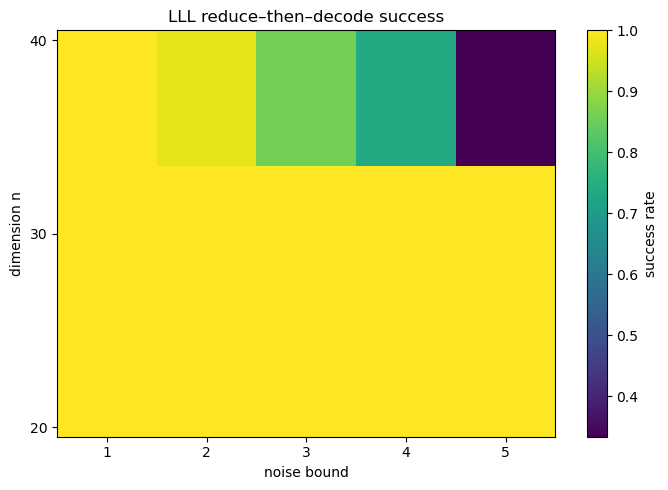

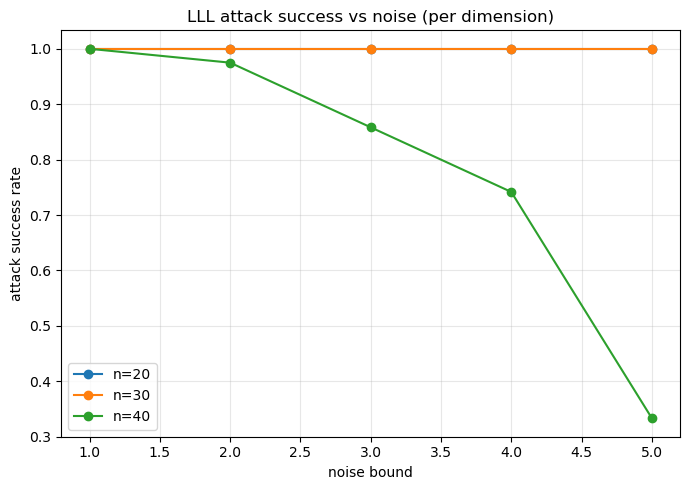

In [23]:
# Visualizations
plot_success_heatmap(records, dim_list, noise_list, title="LLL reduce–then–decode success")
plot_success_vs_noise(records, dim_list, noise_list)

In [9]:

import multiprocessing as mp
from math import sqrt


class GGH_HNF_Cryptosystem:
    """
    GGH-HNF implementation (modified: uses exact nearest-integer rounding on decryption).
    Minimal edits from original implementation_2: only change in decryption rounding.
    """
    def __init__(self, n, spread, hadamard_ratio_threshold, message_bound, noise_bound):
        self.n = n
        self.spread = spread
        self.h_threshold = hadamard_ratio_threshold
        self.msg_bound = message_bound
        self.noise_bound = noise_bound
        self.public_key = None
        self.private_key = None

    def _generate_random_basis(self):
        scale = int(sqrt(self.n) * self.spread)
        R = matrix(ZZ, [[ZZ.random_element(-self.spread, self.spread + 1) for _ in range(self.n)]
                        for _ in range(self.n)])
        return R + scale * identity_matrix(ZZ, self.n)

    def _apply_unimodular_scramble(self, basis):
        P_row = matrix.identity(self.n)
        p_rows = list(range(self.n))
        shuffle(p_rows)
        P_row = P_row[p_rows, :]

        P_col = matrix.identity(self.n)
        p_cols = list(range(self.n))
        shuffle(p_cols)
        P_col = P_col[:, p_cols]

        signs = diagonal_matrix([choice([-1, 1]) for _ in range(self.n)])

        return signs * P_row * basis * P_col

    def generate_keys(self, max_attempts=50):
        for _ in range(max_attempts):
            candidate = self._generate_random_basis()
            candidate = self._apply_unimodular_scramble(candidate)
            if candidate.det() == 0: continue
            if LatticeMetrics.hadamard_ratio(candidate) > self.h_threshold:
                self.private_key = candidate
                self.public_key = candidate.hermite_form()
                return
        raise ValueError(f"Could not generate keys with H-ratio > {self.h_threshold}")

    def encrypt(self, message_vec):
        if self.public_key is None: raise ValueError("Keys not generated")
        noise = vector(ZZ, [ZZ.random_element(-self.noise_bound, self.noise_bound + 1)
                           for _ in range(self.n)])
        ciphertext = vector(ZZ, message_vec) * self.public_key + noise
        return ciphertext  # note: no noise returned (match impl2 behavior)

    def babai_nearest_plane(self, basis, target):
        # Babai nearest plane: using gram_schmidt()
        n = basis.nrows()
        G_star, mu = basis.gram_schmidt()
        b = target.change_ring(QQ)
        for i in range(n - 1, -1, -1):
            numer = b * G_star.row(i)
            denom = (G_star.row(i).norm() ** 2)
            c = numer / denom
            c_int = Integer(c.round())
            b = b - c_int * basis.row(i)
        return target - b  # closest lattice vector

    def GGH_HNF_decryption(self, ciphertext):
        if self.private_key is None: raise ValueError("Keys not generated")
        # Compute approx nearest lattice vector using Babai rounding
        B_inv = self.private_key.inverse().change_ring(QQ)
        t = (ciphertext.change_ring(QQ)) * B_inv
        z = vector(ZZ, [Integer(x.round()) for x in t])
        closest_point = z * self.private_key

        # Recover m: m = closest_point * public_key^-1
        pub_inv = self.public_key.inverse().change_ring(QQ)
        m_plus_e = closest_point.change_ring(QQ) * pub_inv

        b = self.msg_bound
        decrypted_message = vector(ZZ, [
            min(b, max(-b, Integer(x.round()))) for x in m_plus_e
        ])
        return decrypted_message

# LatticeMetrics (same as earlier implementation)
class LatticeMetrics:
    @staticmethod
    def hadamard_ratio(basis):
        try:
            n = basis.nrows()
            det = abs(basis.det())
            if det == 0: return 0.0
            log_det = float(log(det))
            log_prod_norms = sum(float(log(basis.row(i).norm())) for i in range(n))
            log_ratio = (log_det - log_prod_norms) / n
            return exp(log_ratio)
        except Exception as e:
            return 0.0

    @staticmethod
    def orthogonality_defect(basis):
        h = LatticeMetrics.hadamard_ratio(basis)
        return 1.0 / h if h > 0 else float('inf')

# -- Attack helper (LLL + Babai nearest plane) -----------------------
class GGH_Attacker:
    @staticmethod
    def babai_nearest_plane(basis, target):
        # Use the implementation similar to the one in the modified class
        n = basis.nrows()
        G_star, mu = basis.gram_schmidt()
        b = target.change_ring(QQ)
        for i in range(n - 1, -1, -1):
            c = (b * G_star.row(i)) / (G_star.row(i).norm() ** 2)
            c_int = Integer(c.round())
            b = b - c_int * basis.row(i)
        return target - b

    @staticmethod
    def run_lll_attack(public_key, ciphertext, delta=0.99):
        start = time.time()
        B_reduced = public_key.LLL(delta=delta)
        lll_time = time.time() - start

        B_red_qq = B_reduced.change_ring(QQ)
        c_qq = ciphertext.change_ring(QQ)
        closest_vector = GGH_Attacker.babai_nearest_plane(B_red_qq, c_qq)

        P_inv = public_key.inverse().change_ring(QQ)
        m_rec = closest_vector * P_inv
        return vector(ZZ, [Integer(round(x)) for x in m_rec]), lll_time, LatticeMetrics.hadamard_ratio(B_reduced)

# -- Single trial worker ------------------------------------------------
def run_trial(args):
    n, spread, noise, h_thresh, delta, trial_id = args
    try:
        sys = GGH_HNF_Cryptosystem(n, spread, h_thresh, message_bound=10, noise_bound=noise)
        sys.generate_keys()
        # sample message
        msg = vector(ZZ, [randint(-10, 10) for _ in range(n)])
        ctxt = sys.encrypt(msg)

        # run attack
        rec_msg, lll_time, reduced_h_ratio = GGH_Attacker.run_lll_attack(sys.public_key, ctxt, delta)
        success = (rec_msg == msg)

        # metrics
        initial_h_ratio = LatticeMetrics.hadamard_ratio(sys.public_key)
        # compute GS short norms
        GS, mu = sys.public_key.gram_schmidt()
        gs_norms = [GS.row(i).norm() for i in range(sys.n)]
        shortest_gs = min([float(v) for v in gs_norms]) if len(gs_norms) else 0.0

        # measure noise norm (we don't return noise from encrypt in this variant,
        # so recompute by m*H - c; but we don't have noise separately; we can compute residual)
        # compute v = m * H
        v = (vector(ZZ, msg) * sys.public_key)
        noise_est = ctxt - v
        noise_norm = float(noise_est.norm())

        return {
            'dim': n,
            'spread': spread,
            'noise_bound': noise,
            'h_threshold': h_thresh,
            'delta': delta,
            'trial_id': trial_id,
            'success': success,
            'time_lll': lll_time,
            'h_ratio_init': initial_h_ratio,
            'h_ratio_reduced': reduced_h_ratio,
            'shortest_gs_norm': shortest_gs,
            'noise_norm': noise_norm
        }
    except Exception as e:
        return {'error': str(e), 'dim': n, 'spread': spread, 'noise_bound': noise, 'h_threshold': h_thresh, 'trial_id': trial_id}

# -- Experiment orchestration -------------------------------------------
def main_experiment():
    print("="*80)
    print("GGH-HNF LLL Attack Grid Experiment")
    print("="*80)

    # PARAM GRID (adjust as compute allows)
    dimensions = [20, 60, 100, 160]           # example
    spreads = [3, 6, 10]
    noises = [3, 5, 8]
    h_threshold = 0.8
    deltas = [0.75, 0.8, 0.99]
    trials = 5

    tasks = []
    for n in dimensions:
        for s in spreads:
            for noise in noises:
                for delta in deltas:
                    for t in range(trials):
                        tasks.append((n, s, noise, h_threshold, delta, t))

    print(f"Running {len(tasks)} total trials on up to {max(1, mp.cpu_count()-1)} cores...")
    results = []
    with mp.Pool(max(1, mp.cpu_count()-1)) as pool:
        for r in tqdm(pool.imap_unordered(run_trial, tasks), total=len(tasks)):
            if r is not None:
                results.append(r)

    df = pd.DataFrame(results)
    df_filtered = df[df['error'].isnull()] if 'error' in df else df
    # Summaries
    summary = df.groupby(['dim','spread','noise_bound','h_threshold']).agg({
        'success': 'mean',
        'time_lll': 'mean',
        'h_ratio_init': 'mean',
        'h_ratio_reduced': 'mean',
        'shortest_gs_norm': 'mean',
        'noise_norm': 'mean'
    }).reset_index()
    print("\nSummary (sample):")
    print(summary.head(int(20)))

    # save results
    df.to_csv("ggh_hnf_lll_experiment_results.csv", index=False)
    summary.to_csv("ggh_hnf_lll_summary.csv", index=False)
    print("\nSaved results to ggh_hnf_lll_experiment_results.csv and ggh_hnf_lll_summary.csv")

if __name__ == "__main__":
    main_experiment()


GGH-HNF LLL Attack Grid Experiment
Running 540 total trials on up to 11 cores...


100%|███████████████████████████████████████████████████████████████████████████████| 540/540 [1:44:12<00:00, 11.58s/it]



Summary (sample):
    dim spread noise_bound        h_threshold   success  time_lll  \
0    20      3           3  0.800000000000000  1.000000  0.316537   
1    20      3           5  0.800000000000000  0.533333  0.005294   
2    20      3           8  0.800000000000000  0.000000  0.003062   
3    20      6           3  0.800000000000000  1.000000  0.003225   
4    20      6           5  0.800000000000000  1.000000  0.003230   
5    20      6           8  0.800000000000000  0.933333  0.003321   
6    20     10           3  0.800000000000000  1.000000  0.005488   
7    20     10           5  0.800000000000000  0.933333  0.007239   
8    20     10           8  0.800000000000000  1.000000  0.003733   
9    60      3           3  0.800000000000000  0.333333  0.332881   
10   60      3           5  0.800000000000000  0.333333  0.224620   
11   60      3           8  0.800000000000000  0.200000  0.236973   
12   60      6           3  0.800000000000000  0.733333  0.314361   
13   60      6 